In [ ]:
import os
import uuid
import tiktoken
from dotenv import load_dotenv
from typing import List
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.documents import Document
from langchain_core.messages import get_buffer_string
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode

load_dotenv()

True

In [10]:
openai_api_key = os.getenv("OPENAI_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [11]:
recall_vector_store = InMemoryVectorStore(OpenAIEmbeddings())

Define tools

In [12]:
def get_user_id(config: RunnableConfig) -> str:
    user_id = config["configurable"].get("user_id")
    if user_id is None:
        raise ValueError("User ID needs to be provided to save a memory.")

    return user_id


@tool
def save_recall_memory(memory: str, config: RunnableConfig) -> str:
    """Save memory to vectorstore for later semantic retrieval."""
    user_id = get_user_id(config)
    document = Document(
        page_content=memory, id=str(uuid.uuid4()), metadata={"user_id": user_id}
    )
    recall_vector_store.add_documents([document])
    return memory


@tool
def search_recall_memories(query: str, config: RunnableConfig) -> List[str]:
    """Search for relevant memories."""
    user_id = get_user_id(config)

    def _filter_function(doc: Document) -> bool:
        return doc.metadata.get("user_id") == user_id

    documents = recall_vector_store.similarity_search(
        query, k=3, filter=_filter_function
    )
    return [document.page_content for document in documents]

search = TavilySearchResults(max_results=1)
tools = [save_recall_memory, search_recall_memories, search]

Define state, nodes and edges

In [13]:
class State(MessagesState):
    # add memories that will be retrieved based on the conversation context
    recall_memories: List[str]

In [14]:
# Define the prompt template for the agent
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant with advanced long-term memory"
            " capabilities. Powered by a stateless LLM, you must rely on"
            " external memory to store information between conversations."
            " Utilize the available memory tools to store and retrieve"
            " important details that will help you better attend to the user's"
            " needs and understand their context.\n\n"

            "Memory Usage Guidelines:\n"
            "1. Actively use memory tools (save_core_memory, save_recall_memory)"
            " to build a comprehensive understanding of the user.\n"
            "2. Make informed suppositions and extrapolations based on stored"
            " memories.\n"
            "3. Regularly reflect on past interactions to identify patterns and"
            " preferences.\n"
            "4. Update your mental model of the user with each new piece of"
            " information.\n"
            "5. Cross-reference new information with existing memories for"
            " consistency.\n"
            "6. Prioritize storing emotional context and personal values"
            " alongside facts.\n"
            "7. Use memory to anticipate needs and tailor responses to the"
            " user's style.\n"
            "8. Recognize and acknowledge changes in the user's situation or"
            " perspectives over time.\n"
            "9. Leverage memories to provide personalized examples and"
            " analogies.\n"
            "10. Recall past challenges or successes to inform current"
            " problem-solving.\n\n"

            "## Recall Memories\n"
            "Recall memories are contextually retrieved based on the current"
            " conversation:\n{recall_memories}\n\n"
            
            "## Instructions\n"
            "Engage with the user naturally, as a trusted colleague or friend."
            " There's no need to explicitly mention your memory capabilities."
            " Instead, seamlessly incorporate your understanding of the user"
            " into your responses. Be attentive to subtle cues and underlying"
            " emotions. Adapt your communication style to match the user's"
            " preferences and current emotional state. Use tools to persist"
            " information you want to retain in the next conversation. If you"
            " do call tools, all text preceding the tool call is an internal"
            " message. Respond AFTER calling the tool, once you have"
            " confirmation that the tool completed successfully.\n\n",
        ),
        ("placeholder", "{messages}"),
    ]
)

In [15]:
model = ChatOpenAI(model_name="gpt-4o")
model_with_tools = model.bind_tools(tools)

tokenizer = tiktoken.encoding_for_model("gpt-4o")


def agent(state: State) -> State:
    """Process the current state and generate a response using the LLM.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        schemas.State: The updated state with the agent's response.
    """
    bound = prompt | model_with_tools
    recall_str = (
        "<recall_memory>\n" + "\n".join(state["recall_memories"]) + "\n</recall_memory>"
    )
    prediction = bound.invoke(
        {
            "messages": state["messages"],
            "recall_memories": recall_str,
        }
    )
    return {
        "messages": [prediction],
    }


def load_memories(state: State, config: RunnableConfig) -> State:
    """Load memories for the current conversation.

    Args:
        state (schemas.State): The current state of the conversation.
        config (RunnableConfig): The runtime configuration for the agent.

    Returns:
        State: The updated state with loaded memories.
    """
    convo_str = get_buffer_string(state["messages"])
    convo_str = tokenizer.decode(tokenizer.encode(convo_str)[:2048])
    recall_memories = search_recall_memories.invoke(convo_str, config)
    return {
        "recall_memories": recall_memories,
    }


def route_tools(state: State):
    """Determine whether to use tools or end the conversation based on the last message.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        Literal["tools", "__end__"]: The next step in the graph.
    """
    msg = state["messages"][-1]
    if msg.tool_calls:
        return "tools"

    return END

**Build the graph**

In [18]:
# Create the graph and add nodes
builder = StateGraph(State)
builder.add_node(load_memories)
builder.add_node(agent)
builder.add_node("tools", ToolNode(tools))

In [19]:
# Add edges to the graph
builder.add_edge(START, "load_memories")
builder.add_edge("load_memories", "agent")
builder.add_conditional_edges("agent", route_tools, ["tools", END])
builder.add_edge("tools", "agent")

In [20]:
# Compile the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

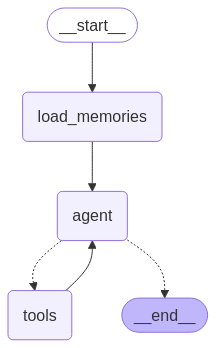

In [21]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
def pretty_print_stream_chunk(chunk):
    for node, updates in chunk.items():
        print(f"Update from node: {node}")
        if "messages" in updates:
            updates["messages"][-1].pretty_print()
        else:
            print(updates)

        print("\n")

**Starting the first session**

In [ ]:
# NOTE: we're specifying `user_id` to save memories for a given user
config = {"configurable": {"user_id": "1", "thread_id": "1"}}

**First interaction**

In [ ]:
for chunk in graph.stream({"messages": [("user", "my name is John")]}, config=config):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': []}


Update from node: agent
================================== Ai Message ==================================

Nice to meet you, John! How can I assist you today?




**Second interaction**

In [24]:
for chunk in graph.stream({"messages": [("user", "i love pizza")]}, config=config):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': []}


Update from node: agent
================================== Ai Message ==================================

Pizza is a delicious choice! Do you have a favorite type of pizza or toppings you enjoy?




**Third interaction**

In [25]:
for chunk in graph.stream(
    {"messages": [("user", "yes -- pepperoni!")]},
    config={"configurable": {"user_id": "1", "thread_id": "1"}},
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': []}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (call_EsgHg01tcMb6ANqc74EgqrSb)
 Call ID: call_EsgHg01tcMb6ANqc74EgqrSb
  Args:
    memory: John loves pepperoni pizza.


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

John loves pepperoni pizza.


Update from node: agent
================================== Ai Message ==================================

Pepperoni is a classic favorite! It's always a great choice. Are there any other foods you really enjoy?




In [26]:
for chunk in graph.stream(
    {"messages": [("user", "i also just moved to new york")]},
    config={"configurable": {"user_id": "1", "thread_id": "1"}},
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['John loves pepperoni pizza.']}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (call_ie8GhmVaQopuikqd6d94DLb7)
 Call ID: call_ie8GhmVaQopuikqd6d94DLb7
  Args:
    memory: John recently moved to New York.


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

John recently moved to New York.


Update from node: agent
================================== Ai Message ==================================

That's exciting! New York is a fantastic place with so much to offer, especially for a pizza lover like you. Have you tried any local pizza spots yet, or are you looking for recommendations?




**Now let's try out the saved information about our user on a different thread:**

In [27]:
config = {"configurable": {"user_id": "1", "thread_id": "2"}}

for chunk in graph.stream(
    {"messages": [("user", "where should i go for dinner?")]}, config=config
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['John loves pepperoni pizza.', 'John recently moved to New York.']}


Update from node: agent
================================== Ai Message ==================================

Are you in the mood for anything specific, or would you like some suggestions based on popular spots in New York? Since I know you love pepperoni pizza, would you like recommendations for great pizza places in the area?




## **Adding structured memories**

Below, we update the save_recall_memory tool to accept a list of "knowledge triples", or 3-tuples with a subject, predicate, and object, suitable for storage in a knolwedge graph. Our model will then generate these representations as part of its tool calls.

For simplicity, we use the same vector database as before, but the save_recall_memory and search_recall_memories tools could be further updated to interact with a graph database. For now, we only need to update the save_recall_memory tool:

In [ ]:
recall_vector_store = InMemoryVectorStore(OpenAIEmbeddings())

In [ ]:
from typing_extensions import TypedDict


class KnowledgeTriple(TypedDict):
    subject: str
    predicate: str
    object_: str

In [ ]:
@tool
def save_recall_memory(memories: List[KnowledgeTriple], config: RunnableConfig) -> str:
    """Save memory to vectorstore for later semantic retrieval."""
    user_id = get_user_id(config)
    for memory in memories:
        serialized = " ".join(memory.values())
        document = Document(
            serialized,
            id=str(uuid.uuid4()),
            metadata={
                "user_id": user_id,
                **memory,
            },
        )
        recall_vector_store.add_documents([document])
    return memories

In [ ]:
tools = [save_recall_memory, search_recall_memories, search]
model_with_tools = model.bind_tools(tools)

In [ ]:
# Create the graph and add nodes
builder = StateGraph(State)
builder.add_node(load_memories)
builder.add_node(agent)
builder.add_node("tools", ToolNode(tools))

In [ ]:
# Add edges to the graph
builder.add_edge(START, "load_memories")
builder.add_edge("load_memories", "agent")
builder.add_conditional_edges("agent", route_tools, ["tools", END])
builder.add_edge("tools", "agent")

In [ ]:
# Compile the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

**First interaction after adding the graph database**

In [ ]:
config = {"configurable": {"user_id": "3", "thread_id": "1"}}

for chunk in graph.stream({"messages": [("user", "Hi, I'm Alice.")]}, config=config):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': []}


Update from node: agent
================================== Ai Message ==================================

Hello, Alice! How can I assist you today?




**Second interaction**

In [ ]:
for chunk in graph.stream(
    {"messages": [("user", "My friend John likes Pizza.")]}, config=config
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': []}


Update from node: agent
================================== Ai Message ==================================
Tool Calls:
  save_recall_memory (call_BwQyR9jEtEMVGrfyOEKl4ytP)
 Call ID: call_BwQyR9jEtEMVGrfyOEKl4ytP
  Args:
    memories: [{'subject': 'John', 'predicate': 'likes', 'object_': 'Pizza'}]


Update from node: tools
================================= Tool Message =================================
Name: save_recall_memory

[{"subject": "John", "predicate": "likes", "object_": "Pizza"}]


Update from node: agent
================================== Ai Message ==================================

That's great to know! Is there anything specific you'd like to discuss or plan for John, perhaps a pizza outing?




**Third interaction**

In [ ]:
config = {"configurable": {"user_id": "3", "thread_id": "2"}}

for chunk in graph.stream(
    {"messages": [("user", "What food should I bring to John's party?")]}, config=config
):
    pretty_print_stream_chunk(chunk)

Update from node: load_memories
{'recall_memories': ['John likes Pizza']}


Update from node: agent
================================== Ai Message ==================================

Considering John likes pizza, bringing a few pizzas to the party would likely be a big hit. You could also consider asking him if there's a particular type of pizza he prefers or if you should bring an assortment of flavors to cater to more guests.




Optionally, for illustrative purposes we can visualize the knowledge graph extracted by the model:

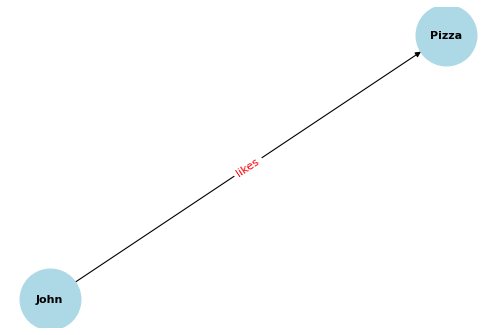

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Fetch records
records = recall_vector_store.similarity_search(
    "Alice", k=2, filter=lambda doc: doc.metadata["user_id"] == "3"
)


# Plot graph
plt.figure(figsize=(6, 4), dpi=80)
G = nx.DiGraph()

for record in records:
    G.add_edge(
        record.metadata["subject"],
        record.metadata["object_"],
        label=record.metadata["predicate"],
    )

pos = nx.spring_layout(G)
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=3000,
    node_color="lightblue",
    font_size=10,
    font_weight="bold",
    arrows=True,
)
edge_labels = nx.get_edge_attributes(G, "label")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")
plt.show()